In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2


In [2]:
pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=bdc756385e570add45494d23079deced87cba1baa6c32296706d7cb0065cf2ef
  Stored in directory: c:\users\prakamya\appdata\local\pip\cache\wheels\46\ef\c3\157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [11]:
DIRECTORY = ('data')
CATEGORIES = ["with_mask", "without_mask"]


In [12]:
print("[INFO] loading images...")

[INFO] loading images...


In [13]:
data = []
labels = []

In [14]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [15]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [46]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [47]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
     input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 2s 0us/step


In [52]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [53]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [54]:
for layer in baseModel.layers:
	layer.trainable = False

In [55]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


C:\Users\PRAKAMYA\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [56]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 310s 9s/step - loss: 0.4903 - accuracy: 0.8333 - val_loss: 0.2140 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 93s 3s/step - loss: 0.1980 - accuracy: 0.9635 - val_loss: 0.0968 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 87s 3s/step - loss: 0.1180 - accuracy: 0.9775 - val_loss: 0.0632 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 94s 3s/step - loss: 0.0782 - accuracy: 0.9897 - val_loss: 0.0433 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 97s 3s/step - loss: 0.0629 - accuracy: 0.9897 - val_loss: 0.0359 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 101s 3s/step - loss: 0.0470 - accuracy: 0.9944 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 87s 3s/step - loss: 0.0380 - accuracy: 0.9954 - val_loss: 0.0236 - val_accuracy: 0

In [57]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [58]:
predIdxs = np.argmax(predIdxs, axis=1)

In [59]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [61]:
print("[INFO] saving mask detector model...")
model.save("mobileNetv2.model", save_format="h5")

[INFO] saving mask detector model...


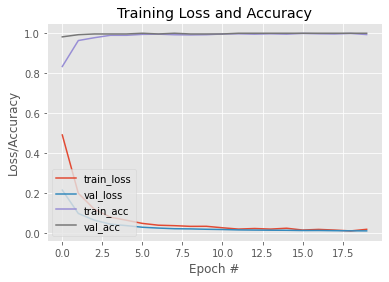

In [62]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")